<a href="https://colab.research.google.com/github/Melo987/-v2/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install matplotlib==3.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l 

In [19]:
class Inception(nn.Module):
  def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
    super(Inception,self).__init__(**kwargs)
    self.p1_1 = nn.Conv2d(in_channels,c1,kernel_size=1)
    self.p2_1 = nn.Conv2d(in_channels,c2[0],kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
    self.p3_1 = nn.Conv2d(in_channels,c3[0],kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
    self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
    self.p4_2 = nn.Conv2d(in_channels,c4,kernel_size=1)

  def forward(self,x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    return torch.cat((p1,p2,p3,p4),dim=1)

In [20]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [21]:
b2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64,192,kernel_size=3,padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [22]:
b3 = nn.Sequential(Inception(192,64,(96,128),(16,32),32),
          Inception(256,128,(128,192),(32,96),64),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [23]:
b4 = nn.Sequential(Inception(480,192,(96,208),(16,48),64),
          Inception(512,160,(112,224),(24,64),64),
          Inception(512,128,(128,256),(24,64),64),
          Inception(512,112,(144,288),(32,64),64),
          Inception(528,256,(160,320),(32,128),128),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [28]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

In [29]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [30]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [31]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.245, train acc 0.907, test acc 0.893
1366.6 examples/sec on cuda:0


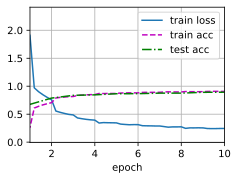

In [32]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())